In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from matplotlib.pyplot import imshow
from sklearn.metrics import f1_score
from torch.optim import SGD, Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

c:\Python310\lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.3)
  from scipy.sparse import csr_matrix, issparse


cuda


In [2]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(180, 180)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dir = "../data/train"  # path to the train folder
validation_dir = "../data/validation"  # path to the validation folder
test_dir = "../data/test"  # path to test folder

train_data = datasets.ImageFolder(root=train_dir, transform=transform)

validation_data = datasets.ImageFolder(root=validation_dir, transform=transform)

test_data = datasets.ImageFolder(root=test_dir, transform=transform)

print(
    f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}\n\nTest data:\n{test_data}"
)

data_loaders = {
    "train": DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2),
    "validation": DataLoader(
        validation_data, batch_size=4, shuffle=True, num_workers=2
    ),
}

Train data:
Dataset ImageFolder
    Number of datapoints: 3689
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 495
    Root location: ../data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 494
    Root location: ../data/test
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5,

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 22 * 22, 256)
        self.act4 = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out = self.pool2(self.act2(self.bn2(self.conv2(out))))
        out = self.pool3(self.act3(self.bn3(self.conv3(out))))
        out = out.view(out.size(0), -1)
        out = self.act4(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out


model = SimpleCNN().to(device)

In [4]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss, correct = 0, 0
    size = len(dataloader.dataset)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    return train_loss / len(dataloader), accuracy


def validate(dataloader, model, loss_fn):
    model.eval()
    validation_loss, correct = 0, 0
    size = len(dataloader.dataset)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    return validation_loss / len(dataloader), accuracy

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizers = {
    "SGD": lambda params: SGD(params, lr=0.001),
    "Adam": lambda params: Adam(params, lr=0.001),
}
epochs = 20

In [ ]:

results = {
    "optimizer": [],
    "train_acc": [],
    "validation_acc": [],
    "train_loss": [],
    "validation_loss": [],
}



for optimizer_name, optimizer_fn in optimizers.items():

    print(f"Training with optimizer: {optimizer_name}")

    model = SimpleCNN().to(device)  # Reinitialize model for each optimizer

    optimizer = optimizer_fn(model.parameters())


    train_accuracies = []
    validation_accuracies = []
    train_losses = []
    validation_losses = []


    for epoch in range(epochs):

        print(f"Epoch {epoch + 1}/{epochs}")

        train_loss, train_acc = train(data_loaders["train"], model, loss_fn, optimizer)

        val_loss, val_acc = validate(data_loaders["validation"], model, loss_fn)


        train_accuracies.append(train_acc)

        validation_accuracies.append(val_acc)
        train_losses.append(train_loss)
        validation_losses.append(val_loss)


        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")











    results["optimizer"].append(optimizer_name)

    results["train_acc"].append(train_accuracies)  # Final train accuracy
    results["validation_acc"].append(validation_accuracies)  # Final validation accuracy
    results["train_loss"].append(train_losses[-1])
    results["validation_loss"].append(validation_losses[-1])

Training with optimizer: SGD
Epoch 1/20
Train Loss: 0.6087, Validation Loss: 0.6005
Train Accuracy: 69.64%, Validation Accuracy: 69.49%
Epoch 2/20
Train Loss: 0.5612, Validation Loss: 0.5156
Train Accuracy: 71.48%, Validation Accuracy: 73.94%
Epoch 3/20
Train Loss: 0.4780, Validation Loss: 0.4008
Train Accuracy: 76.12%, Validation Accuracy: 80.20%
Epoch 4/20
Train Loss: 0.3641, Validation Loss: 0.3149
Train Accuracy: 83.17%, Validation Accuracy: 88.08%
Epoch 5/20
Train Loss: 0.2868, Validation Loss: 0.3250
Train Accuracy: 87.96%, Validation Accuracy: 83.84%
Epoch 6/20
Train Loss: 0.2512, Validation Loss: 0.3388
Train Accuracy: 89.40%, Validation Accuracy: 85.45%
Epoch 7/20
Train Loss: 0.2071, Validation Loss: 0.2543
Train Accuracy: 91.81%, Validation Accuracy: 89.29%
Epoch 8/20
Train Loss: 0.1765, Validation Loss: 0.1871
Train Accuracy: 92.65%, Validation Accuracy: 91.72%
Epoch 9/20
Train Loss: 0.1532, Validation Loss: 0.3015
Train Accuracy: 93.93%, Validation Accuracy: 88.89%
Epoch 10

In [7]:
import json

with open("./results/sgd_adam_1.json", "w") as file:
    json.dump(results, file, indent=4)

In [34]:
results_plot = {
    "optimizer": results["optimizer"],
    "train_acc": [results["train_acc"][0][-1], results["train_acc"][1][-1]],
    "validation_acc": [
        results["validation_acc"][0][-1],
        results["validation_acc"][1][-1],
    ],
    "train_loss": results["train_loss"],
    "validation_loss": results["validation_loss"],
}
print(results_plot)

{'optimizer': ['SGD', 'Adam'], 'train_acc': [99.81024667931689, 98.37354296557332], 'validation_acc': [95.95959595959596, 93.93939393939394], 'train_loss': [0.009786949082670322, 0.041876561659785275], 'validation_loss': [0.12827080108894803, 0.24091423587873287]}


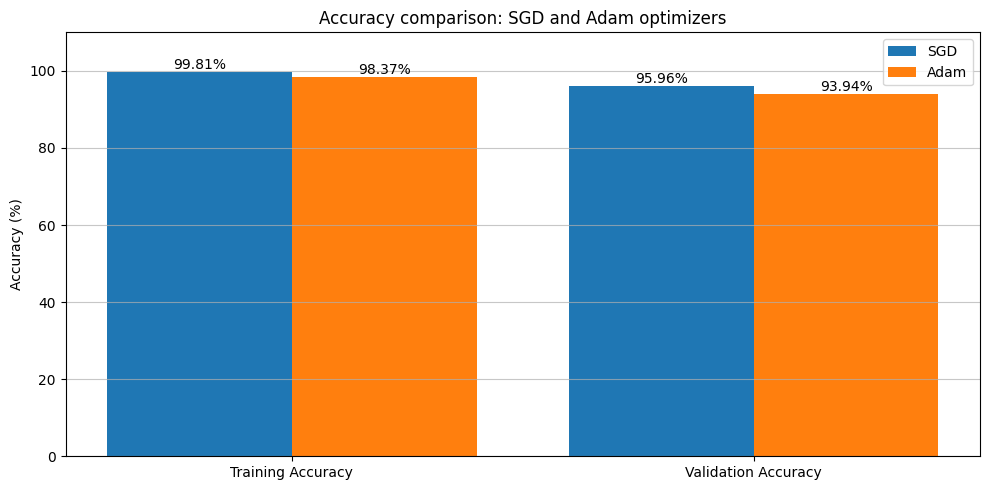

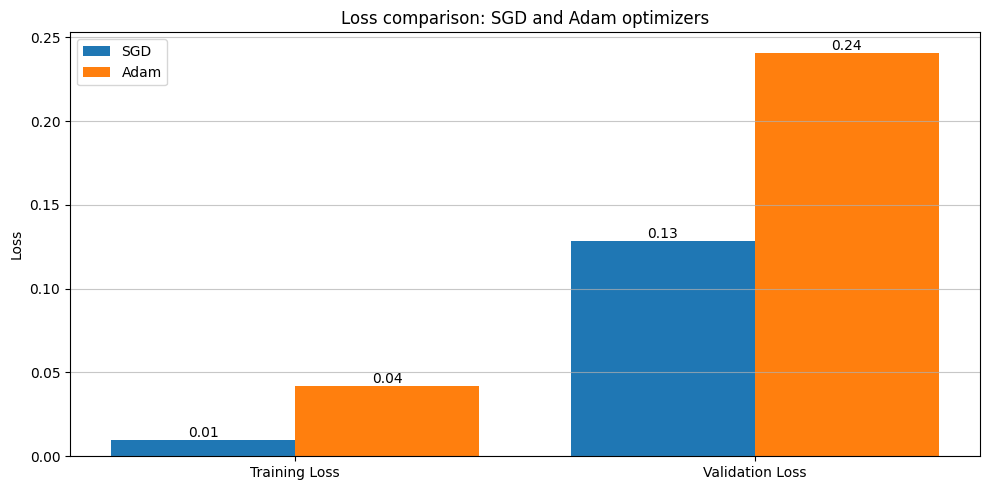

In [44]:
# Plot results
plt.figure(figsize=(10, 5))

x = range(len(results["optimizer"]))
width = 0.4

# Train and Validation accuracy side by side for each optimizer
train_bar = plt.bar(
    [i - width / 2 for i in x],
    [results_plot["train_acc"][0],results_plot["validation_acc"][0] ],
    width=width,
    label="SGD",
)
val_bar = plt.bar(
    [i + width / 2 for i in x],
    [results_plot["train_acc"][1], results_plot["validation_acc"][1]],
    width=width,
    label="Adam",
)

for bar in train_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}%",
        ha="center",
        va="bottom",
    )
for bar in val_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}%",
        ha="center",
        va="bottom",
    )

plt.xticks(x, ["Training Accuracy", "Validation Accuracy"])
plt.title("Accuracy comparison: SGD and Adam optimizers")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 110)
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Plot results
plt.figure(figsize=(10, 5))

x = range(len(results["optimizer"]))
width = 0.4

# Train and Validation accuracy side by side for each optimizer
train_bar = plt.bar(
    [i - width / 2 for i in x],
    [results_plot["train_loss"][0], results_plot["validation_loss"][0]],
    width=width,
    label="SGD",
)
val_bar = plt.bar(
    [i + width / 2 for i in x],
    [results_plot["train_loss"][1], results_plot["validation_loss"][1]],
    width=width,
    label="Adam",
)

for bar in train_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}",
        ha="center",
        va="bottom",
    )
for bar in val_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}",
        ha="center",
        va="bottom",
    )

plt.xticks(x, ["Training Loss", "Validation Loss"])
plt.title("Loss comparison: SGD and Adam optimizers")
plt.ylabel("Loss")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
print(results)

{'optimizer': ['SGD', 'Adam'], 'train_acc': [[69.63946869070209, 71.48278666305232, 76.11818921116834, 83.16616969368393, 87.96421794524261, 89.40092165898618, 91.81349959338574, 92.65383572783952, 93.92789373814041, 94.7682298725942, 95.47302792084575, 96.47600975874221, 97.6958525345622, 97.80428300352399, 98.59040390349688, 98.31932773109244, 98.80726484142043, 98.80726484142043, 99.512062889672, 99.81024667931689], [73.59718080780699, 84.44022770398482, 87.34074274871239, 89.56356736242884, 91.84060721062619, 93.30441854161019, 95.17484413120087, 95.39170506912443, 95.85253456221199, 96.15071835185687, 96.42179452426132, 97.61452968284088, 97.42477636215777, 98.02114394144755, 98.26511249661155, 98.18378964489021, 97.83139062076444, 98.56329628625643, 98.31932773109244, 98.37354296557332]], 'validation_acc': [[69.4949494949495, 73.93939393939394, 80.20202020202021, 88.08080808080808, 83.83838383838383, 85.45454545454545, 89.29292929292929, 91.71717171717172, 88.88888888888889, 93.1